## This notebook implements the SDP method on the University of Houston RGB and Hyperspectral images

Imports

In [1]:
import numpy as np
import scipy.io as sio
import time
import random
import cv2
import os
from spectral import *
from tqdm.notebook import tqdm
from tqdm import trange
import math
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.special import gamma, kv, erf
import scipy.sparse as sp
from enum import Enum
from dataclasses import dataclass
from typing import Tuple

import torch
from torch import Tensor
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init    
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchsummary
import torchprofile
from fvcore.nn import FlopCountAnalysis, parameter_count_table, parameter_count

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set random seed for reproducibility
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_random_seed()

Helper Functions

In [3]:
# Function to downsample an image by a given factor
def downsample_image(image, factor):
    # Ensure the input image is a NumPy array
    if not isinstance(image, np.ndarray):
        image = np.array(image)
    
    # Get the dimensions of the image
    height, width, channels = image.shape
    
    # Initialize a list to hold the downsampled channels
    downsampled_channels = []
    
    # Downsample each channel individually
    for c in range(channels):
        channel = image[:, :, c]
        downsampled_channel = cv2.resize(channel, (width // factor, height // factor), interpolation=cv2.INTER_AREA)
        downsampled_channels.append(downsampled_channel)
    
    # Stack the downsampled channels back together
    downsampled_image = np.stack(downsampled_channels, axis=-1)
    
    return downsampled_image

# Function to downsample an image to a reference shape
def downsample_to_shape(image, target_height, target_width):
    # Ensure the input image is a NumPy array
    if not isinstance(image, np.ndarray):
        image = np.array(image)

    # Initialize a list to hold the resized channels
    resized_channels = []

    # Resize each channel individually
    for c in range(image.shape[2]):
        channel = image[:, :, c]
        resized_channel = cv2.resize(channel, (target_width, target_height), interpolation=cv2.INTER_AREA)
        resized_channels.append(resized_channel)

    # Stack the resized channels back together
    resized_image = np.stack(resized_channels, axis=-1)

    return resized_image

# Function to normalize an image between 0 and 1 safely
def normalize(image):
    """
    Normalize an image to the range [0, 1] while clipping outliers.
    
    Parameters:
    -----------
    image : np.ndarray
        Input image with arbitrary range values.
    
    Returns:
    --------
    normalized_image : np.ndarray
        Normalized image in range [0, 1].
    """
    min_val, max_val = np.percentile(image, [1, 99])
    return (np.clip(image, min_val, max_val) - min_val) / (max_val - min_val)

Functions to visualize the inputs

In [4]:
# Function to visualize an HSI
def visualize_hsi(img1, img2, bands, title1, title2):
    """
    Visualize two hyperspectral images side by side using RGB representations.

    Parameters:
    -----------
    img1 : np.ndarray
        First hyperspectral image.
    img2 : np.ndarray
        Second hyperspectral image.
    bands : tuple
        Band indices to use for RGB representation (applied to both images).
    title1 : str
        Title for the first image.
    title2 : str
        Title for the second image.
    """
    rgb1 = get_rgb(img1, bands)
    rgb2 = get_rgb(img2, bands)

    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    
    axs[0].imshow(rgb1)
    axs[0].set_title(title1)
    axs[0].axis('on')

    axs[1].imshow(rgb2)
    axs[1].set_title(title2)
    axs[1].axis('on')

    plt.tight_layout()
    plt.show()

In [5]:
# Function to visualize an HSI
def visualize_hsi_single(img1, bands, title1):
    """
    Visualize a hyperspectral image using RGB representations.

    Parameters:
    -----------
    img1 : np.ndarray
        First hyperspectral image.
    bands : tuple
        Band indices to use for RGB representation
    title1 : str
        Title for the first image.
    """
    rgb1 = get_rgb(img1, bands)

    fig, ax = plt.subplots(figsize=(8, 8))
    
    ax.imshow(rgb1)
    ax.set_title(title1)
    ax.axis('on')

    plt.tight_layout()
    plt.show()

In [6]:
band_specs = np.array([
            [480.0, 421.0, 539.0],  # Blue
            [552.0, 480.0, 624.0],  # Green
            [666.0, 602.0, 729.0],  # Red
        ], dtype=np.float32)

In [7]:
# Function to apply SRF to an image
def apply_srf(
    hyper_image: np.ndarray,
    band_specs: np.ndarray,
    fwhm_factor: float = 4.2
):
    """
    Apply a Gaussian-based SRF (based on band_specs) to the given HR hyperspectral image.
    
    Unlike the previous version, this function infers the number of HSI bands (L) 
    from hyper_image.shape, and automatically constructs a linearly-spaced 
    wavelength array from the minimum lower_edge to the maximum upper_edge 
    in band_specs.

    Parameters
    ----------
    hyper_image : np.ndarray
        (rows, cols, L) float32 (or will be converted). The high-resolution HSI.
    band_specs : np.ndarray
        (num_bands, 3) array, each row = [center_nm, low_edge_nm, upper_edge_nm].
    fwhm_factor : float
        Factor to convert from (upper_edge - lower_edge) to approximate standard deviation.
        By default 4.2, typical ratio (FWHM / (2.355...) or so for a Gaussian).

    Returns
    -------
    ms_image : np.ndarray
        (rows, cols, num_bands). The resulting multi/pan/RGB image.
    srf : np.ndarray
        (num_bands, L). The spectral response function for each output band
        across the L inferred HSI wavelength positions.
    auto_wavelengths : np.ndarray
        (L,) The automatically-generated wavelength array spanning 
        [min_lower_edge, max_upper_edge].
    """

    # 1) Ensure float32
    hyper_image = hyper_image.astype(np.float32)
    rows, cols, L = hyper_image.shape

    # 2) Determine the min/max edges from band_specs
    #    We will assume the entire HSI covers this range uniformly.
    #    E.g. for IKONOS Panchromatic: [409, 1048], etc.
    min_lower_edge = band_specs[:, 1].min()
    max_upper_edge = band_specs[:, 2].max()

    # 3) Construct a linearly-spaced wavelength array of length L
    #    from min_lower_edge to max_upper_edge, inclusive
    auto_wavelengths = np.linspace(min_lower_edge, max_upper_edge, L).astype(np.float32)
    # Shape: (L,)  We'll reshape to (1, L) for broadcasting
    wave_2d = auto_wavelengths[None, :]  # shape => (1, L)

    # 4) Prepare the SRF array
    num_bands = band_specs.shape[0]
    srf = np.zeros((num_bands, L), dtype=np.float32)

    for i in range(num_bands):
        center_nm = band_specs[i, 0]
        low_nm    = band_specs[i, 1]
        high_nm   = band_specs[i, 2]

        # approximate standard deviation from (high - low) / fwhm_factor
        std_nm = (high_nm - low_nm) / fwhm_factor

        # Gaussian SRF across all L wavelengths
        # shape => (1, L); after the operation => (L,) effectively
        srf_i = np.exp(-0.5 * ((wave_2d - center_nm) / std_nm) ** 2)

        # Normalize so the sum of srf_i is 1 across the L channels
        sum_i = srf_i.sum()
        if sum_i > 1e-8:
            srf_i /= sum_i

        srf[i, :] = srf_i

    # 5) Now srf has shape (num_bands, L). We want to apply it to hyper_image:
    #    hyper_image: (rows, cols, L)
    #    srf^T: (L, num_bands)
    # => tensordot => (rows, cols, num_bands)
    srf_t = srf.T  # shape => (L, num_bands)
    ms_image = np.tensordot(hyper_image, srf_t, axes=([2], [0]))  # => (rows, cols, num_bands)

    # 6) Convert to float32
    ms_image = ms_image.astype(np.float32)

    return ms_image, srf, auto_wavelengths

Importing the University of Houston images

In [8]:
# Get the current working directory
notebook_directory = os.getcwd()

# Define the relative path to the dataset
dataset_relative_path = "../../../Datasets/Real_world_Fusion_based_HSI_Super_Resolution_data/"

# Construct the full path to the dataset
dataset_path = os.path.join(notebook_directory, dataset_relative_path)

# Normalize the path to remove redundancies
normalized_dataset_path = os.path.normpath(dataset_path)

# Define the data file path
hsi_1_file_path = os.path.join(normalized_dataset_path, 'hsi_1.mat')
hsi_2_file_path = os.path.join(normalized_dataset_path, 'hsi_2.mat')
rgb_1_file_path = os.path.join(normalized_dataset_path, 'rgb_image_1.tif')
rgb_2_file_path = os.path.join(normalized_dataset_path, 'rgb_image_2.tif')

In [9]:
def extract_aligned_patches(lr_hsi, hr_rgb, hsi_center_y, hsi_center_x,
                            hsi_patch_size=64, rgb_scale_factor=20, rgb_downsampled_size=512):
    """
    Extract a 64x64 patch from the LR HSI centered at (hsi_center_y, hsi_center_x),
    and the corresponding 1280x1280 patch from the HR RGB image centered at the
    scaled coordinates. Then downsample the RGB patch to 512x512.

    Parameters:
    -----------
    lr_hsi : np.ndarray
        Low-resolution HSI image of shape (H_lr, W_lr, C_hsi).
    hr_rgb : np.ndarray
        High-resolution RGB image of shape (H_hr, W_hr, 3).
    hsi_center_y : int
        Y-coordinate of the HSI patch center.
    hsi_center_x : int
        X-coordinate of the HSI patch center.
    hsi_patch_size : int
        Patch size for the HSI (default: 64).
    rgb_scale_factor : int
        Scaling factor between HSI and RGB resolutions (default: 20).
    rgb_downsampled_size : int
        Final size of the RGB patch after downsampling (default: 512).

    Returns:
    --------
    hsi_patch : np.ndarray
        Extracted HSI patch of shape (hsi_patch_size, hsi_patch_size, C_hsi).
    rgb_patch_downsampled : np.ndarray
        Downsampled RGB patch of shape (rgb_downsampled_size, rgb_downsampled_size, 3).
    """
    
    # --- HSI patch extraction ---
    half_hsi = hsi_patch_size // 2
    hsi_top = hsi_center_y - half_hsi
    hsi_left = hsi_center_x - half_hsi

    if (hsi_top < 0 or hsi_left < 0 or 
        hsi_top + hsi_patch_size > lr_hsi.shape[0] or 
        hsi_left + hsi_patch_size > lr_hsi.shape[1]):
        raise ValueError("HSI patch goes out of bounds.")

    hsi_patch = lr_hsi[
        hsi_top : hsi_top + hsi_patch_size,
        hsi_left : hsi_left + hsi_patch_size,
        :
    ]

    # --- RGB patch extraction ---
    rgb_patch_size = hsi_patch_size * rgb_scale_factor
    half_rgb = rgb_patch_size // 2
    rgb_center_y = hsi_center_y * rgb_scale_factor
    rgb_center_x = hsi_center_x * rgb_scale_factor
    rgb_top = rgb_center_y - half_rgb
    rgb_left = rgb_center_x - half_rgb

    if (rgb_top < 0 or rgb_left < 0 or 
        rgb_top + rgb_patch_size > hr_rgb.shape[0] or 
        rgb_left + rgb_patch_size > hr_rgb.shape[1]):
        raise ValueError("RGB patch goes out of bounds.")

    rgb_patch = hr_rgb[
        rgb_top : rgb_top + rgb_patch_size,
        rgb_left : rgb_left + rgb_patch_size,
        :
    ]

    # --- Downsample the RGB patch ---
    rgb_patch_downsampled = cv2.resize(
        rgb_patch,
        (rgb_downsampled_size, rgb_downsampled_size),
        interpolation=cv2.INTER_AREA
    )

    return hsi_patch, rgb_patch_downsampled

In [10]:
hsi_1 = sio.loadmat(hsi_1_file_path)
hsi_1_image = hsi_1['topLeft']

RGB_1 = cv2.imread(rgb_1_file_path, cv2.IMREAD_UNCHANGED)
# Convert to NumPy array
RGB_1_image = np.array(RGB_1)

hsi_patch_1, rgb_patch_1 = extract_aligned_patches(
    lr_hsi=hsi_1_image,
    hr_rgb=RGB_1_image,
    hsi_center_y=400,
    hsi_center_x=450
)

hsi_1_image = normalize(hsi_patch_1)
RGB_1_image = normalize(rgb_patch_1)

In [11]:
hsi_2 = sio.loadmat(hsi_2_file_path)
hsi_2_image = hsi_2['bottomRight']

RGB_2 = cv2.imread(rgb_2_file_path, cv2.IMREAD_UNCHANGED)
# Convert to NumPy array
RGB_2_image = np.array(RGB_2)

hsi_patch_2, rgb_patch_2 = extract_aligned_patches(
    lr_hsi=hsi_2_image,
    hr_rgb=RGB_2_image,
    hsi_center_y=400,
    hsi_center_x=400
)

hsi_2_image = normalize(hsi_patch_2)
RGB_2_image = normalize(rgb_patch_2)

Establishing training and inference images for the super resolution method

UH Hyperspectral image 1 inference shape:  (64, 64, 50)
UH Hyperspectral image 2 inference shape:  (64, 64, 50)


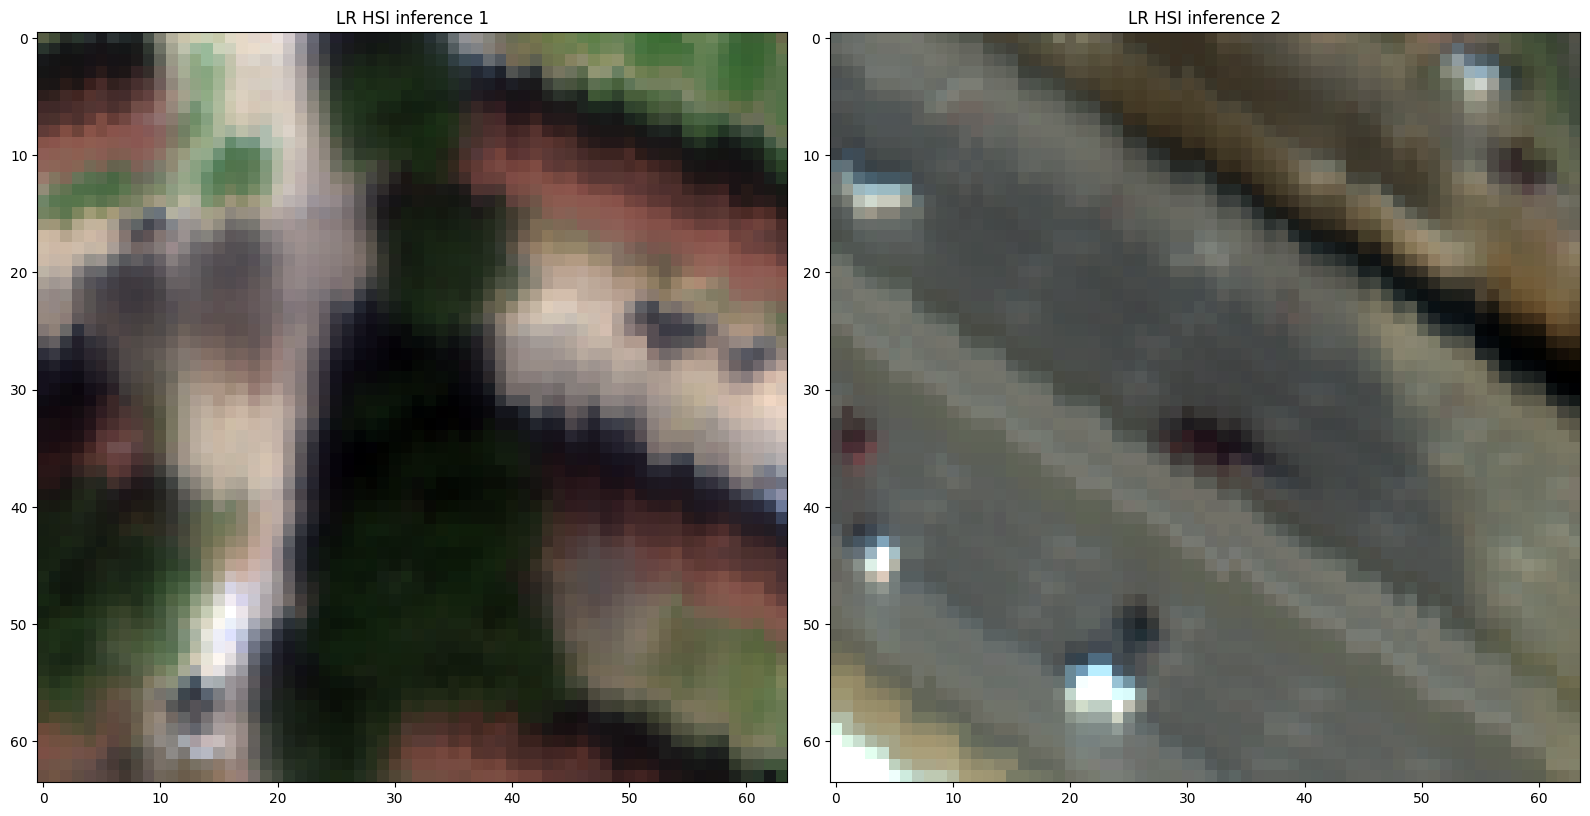

In [12]:
LR_HSI_test_1 = hsi_1_image
print("UH Hyperspectral image 1 inference shape: ", hsi_1_image.shape)

LR_HSI_test_2 = hsi_2_image
print("UH Hyperspectral image 2 inference shape: ", hsi_1_image.shape)

visualize_hsi(LR_HSI_test_1, LR_HSI_test_2, (20,13,8), "LR HSI inference 1", "LR HSI inference 2")

UH RGB image 1 inference shape:  (512, 512, 3)
UH RGB image 2 inference shape:  (512, 512, 3)


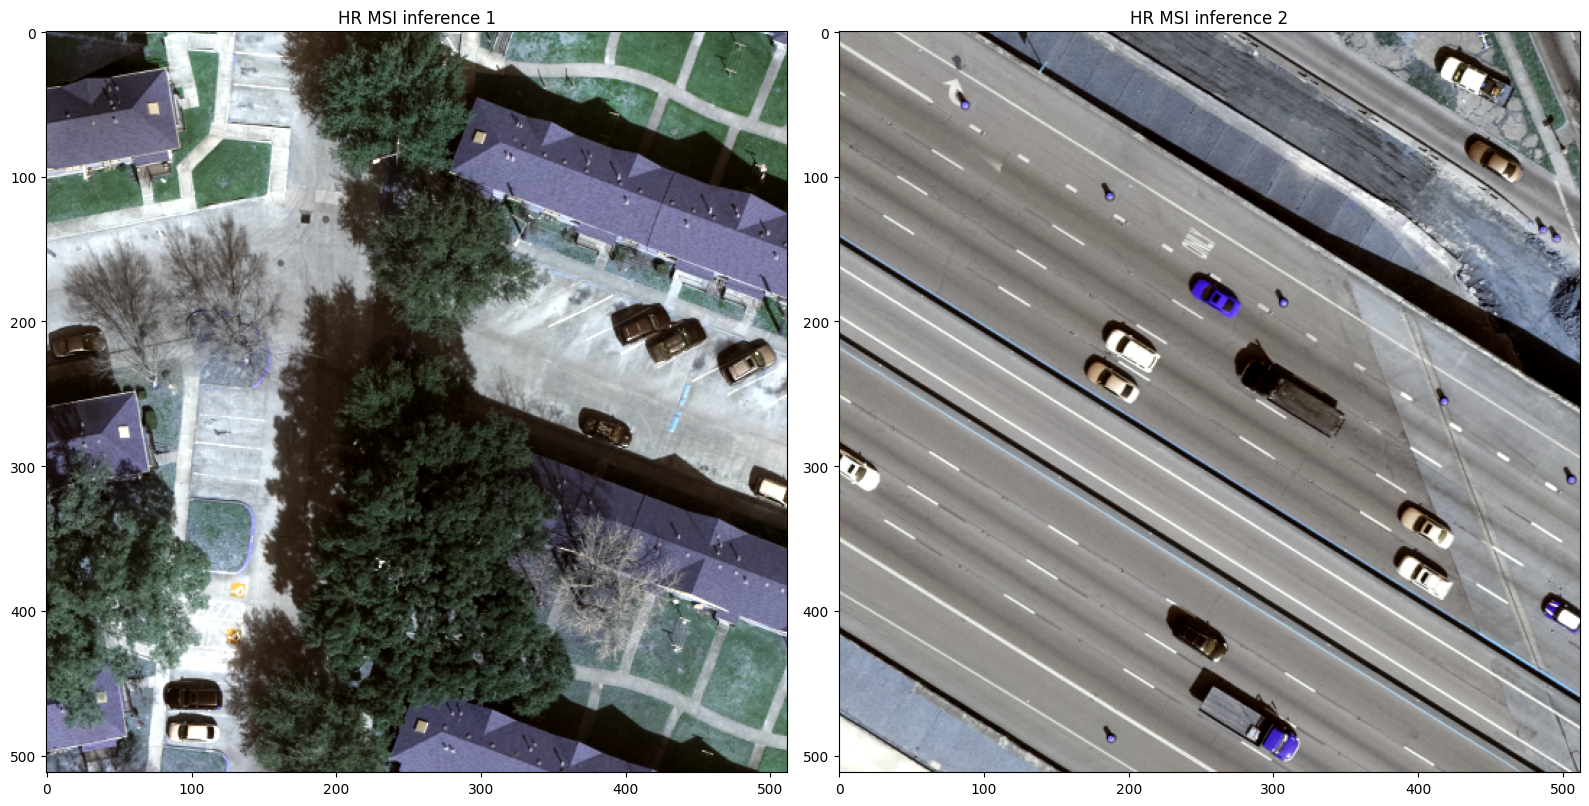

In [13]:
HR_MSI_test_1 = RGB_1_image
print("UH RGB image 1 inference shape: ", HR_MSI_test_1.shape)

HR_MSI_test_2 = RGB_2_image
print("UH RGB image 2 inference shape: ", HR_MSI_test_2.shape)

visualize_hsi(HR_MSI_test_1, HR_MSI_test_2, (0,1,2), "HR MSI inference 1", "HR MSI inference 2")

SDP: A Spectral Diffusion Prior for Unsupervised Hyperspectral Image Super-Resolution implementation from their GitHub

In [14]:
def get_flops_fvcore(model, inputs):
    """
    Estimate FLOPs and parameter count using fvcore.

    Parameters
    ----------
    model : torch.nn.Module
        Your model.
    inputs : tuple
        Tuple of input tensors (e.g., (real_input_tensor,)).

    Returns
    -------
    flops_total : int
        Total number of FLOPs.
    total_params : int
        Total number of parameters.
    param_table : str
        Table showing parameters by layer.
    """
    model.eval()
    with torch.no_grad():
        flops = FlopCountAnalysis(model, inputs)
        flops_total = flops.total()

        params = parameter_count(model)
        total_params = sum(params.values())
        param_table = parameter_count_table(model, max_depth=2)

    return flops_total, total_params, param_table

In [15]:
# model/gaussian_diffusion.py

# beta schedule
def linear_beta_schedule(timesteps):
    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float64)


def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype=torch.float64)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)


# some helpful functions to compute loss
def normal_kl(mean1, logvar1, mean2, logvar2):
    """
    KL divergence between normal distributions parameterized by mean and log-variance.
    """
    return 0.5 * (-1.0 + logvar2 - logvar1 + torch.exp(logvar1 - logvar2) +
                  ((mean1 - mean2) ** 2) * torch.exp(-logvar2))


def approx_standard_normal_cdf(x):
    """
    A fast approximation of the cumulative distribution function of the standard normal.
    """
    return 0.5 * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * (x ** 3))))


def discretized_gaussian_log_likelihood(x, means, log_scales):
    """
    Compute the log-likelihood of a Gaussian distribution discretizing to a
    given image, using the eq(13) of the paper DDPM.
    """
    assert x.shape == means.shape == log_scales.shape

    centered_x = x - means
    inv_stdv = torch.exp(-log_scales)
    plus_in = inv_stdv * (centered_x + 1. / 255.)
    cdf_plus = approx_standard_normal_cdf(plus_in)
    min_in = inv_stdv * (centered_x - 1. / 255.)
    cdf_min = approx_standard_normal_cdf(min_in)
    log_cdf_plus = torch.log(cdf_plus.clamp(min=1e-12))
    log_one_minus_cdf_min = torch.log((1.0 - cdf_min).clamp(min=1e-12))
    cdf_delta = cdf_plus - cdf_min

    log_probs = torch.where(x < -0.999, log_cdf_plus,
                            torch.where(x > 0.999,
                                        log_one_minus_cdf_min,
                                        torch.log(cdf_delta.clamp(min=1e-12))))

    return log_probs


class GaussianDiffusion:
    def __init__(
            self,
            denoise_fn,
            timesteps=1000,
            beta_schedule='linear',
            improved=False
    ):
        self.denoise_fn = denoise_fn
        self.timesteps = timesteps
        self.improved = improved  # improved DDPM

        if beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps)
        elif beta_schedule == 'cosine':
            betas = cosine_beta_schedule(timesteps)
        else:
            raise ValueError(f'unknown beta schedule {beta_schedule}')
        self.betas = betas

        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.)

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
                self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        # below: log calculation clipped because the posterior variance is 0 at the beginning
        # of the diffusion chain
        # self.posterior_log_variance_clipped = torch.log(self.posterior_variance.clamp(min=1e-20))
        self.posterior_log_variance_clipped = torch.log(
            torch.cat([self.posterior_variance[1:2], self.posterior_variance[1:]])
        )

        self.posterior_mean_coef1 = (
                self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
                (1.0 - self.alphas_cumprod_prev)
                * torch.sqrt(self.alphas)
                / (1.0 - self.alphas_cumprod)
        )

    # get the param of given timestep t
    def _extract(self, a, t, x_shape):
        batch_size = t.shape[0]
        out = a.to(t.device).gather(0, t).float()
        out = out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))
        return out

    # forward diffusion (using the nice property): q(x_t | x_0)
    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)

        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

    # Get the mean and variance of q(x_t | x_0).
    def q_mean_variance(self, x_start, t):
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = self._extract(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance

    # Compute the mean and variance of the diffusion posterior: q(x_{t-1} | x_t, x_0)
    def q_posterior_mean_variance(self, x_start, x_t, t):
        posterior_mean = (
                self._extract(self.posterior_mean_coef1, t, x_t.shape) * x_start
                + self._extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = self._extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = self._extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    # compute x_0 from x_t and pred noise: the reverse of `q_sample`
    def predict_start_from_noise(self, x_t, t, noise):
        return (
                self._extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
                self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )

    # compute predicted mean and variance of p(x_{t-1} | x_t)
    def p_mean_variance(self, x_t, t, clip_denoised=True):
        if self.improved is False:
            # predict noise using model
            pred_noise = self.denoise_fn(x_t, t)
            # get the predicted x_0: different from the algorithm2 in the paper
            x_recon = self.predict_start_from_noise(x_t, t, pred_noise)
            if clip_denoised:
                x_recon = torch.clamp(x_recon, min=-1., max=1.)
            model_mean, model_variance, model_log_variance = \
                self.q_posterior_mean_variance(x_recon, x_t, t)
        else:
            # predict noise and variance_vector using model
            model_output = self.denoise_fn(x_t, t)
            pred_noise, pred_variance_v = torch.chunk(model_output, 2, dim=1)
            # compute predicted variance by eq(15) in the paper
            min_log_variance = self._extract(self.posterior_log_variance_clipped, t, x_t.shape)  # beta_t~
            max_log_variance = self._extract(torch.log(self.betas), t, x_t.shape)  # beta_t
            # The predict value is in [-1, 1], we should convert it to [0, 1]
            frac = (pred_variance_v + 1.) / 2.
            model_log_variance = frac * max_log_variance + (1. - frac) * min_log_variance
            model_variance = torch.exp(model_log_variance)
            # get the predicted x_0: different from the algorithm2 in the paper
            x_recon = self.predict_start_from_noise(x_t, t, pred_noise)
            if clip_denoised:
                x_recon = torch.clamp(x_recon, min=-1., max=1.)
            model_mean, _, _ = \
                self.q_posterior_mean_variance(x_recon, x_t, t)
        return model_mean, model_variance, model_log_variance

    # denoise_step: sample x_{t-1} from x_t and pred_noise
    @torch.no_grad()
    def p_sample(self, x_t, t, clip_denoised=True):
        # predict mean and variance
        model_mean, _, model_log_variance = self.p_mean_variance(x_t, t, clip_denoised=clip_denoised)
        noise = torch.randn_like(x_t)
        # no noise when t == 0
        nonzero_mask = ((t != 0).float().view(-1, *([1] * (len(x_t.shape) - 1))))
        # compute x_{t-1}
        pred_img = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise
        return pred_img

    # denoise: reverse diffusion
    @torch.no_grad()
    def p_sample_loop(self, shape, device, continuous=False, idx=None):
        batch_size = shape[0]
        # start from pure noise (for each example in the batch)
        img = torch.randn(shape, device=device)
        if continuous is False:
            for i in tqdm(reversed(range(0, self.timesteps)), desc='sampling loop time step', total=self.timesteps):
                img = self.p_sample(img, torch.full((batch_size,), i, device=device, dtype=torch.long))
            return img
        else:
            imgs = [img.cpu().detach().numpy()]
            for i in tqdm(reversed(range(0, self.timesteps)), desc='sampling loop time step', total=self.timesteps):
                img = self.p_sample(img, torch.full((batch_size,), i, device=device, dtype=torch.long))
                if idx[i] == 1:
                    imgs.append(img.cpu().detach().numpy())
            return imgs

    # sample new images
    @torch.no_grad()
    def sample(self, shape, device, continuous=False, idx=None):
        return self.p_sample_loop(shape=shape, device=device, continuous=continuous, idx=idx)

    # use ddim to sample
    @torch.no_grad()
    def ddim_sample(
            self,
            x_cond,
            image_size,
            batch_size=8,
            channels=3,
            ddim_timesteps=50,
            ddim_discr_method="uniform",
            ddim_eta=0.0,
            clip_denoised=True):
        # make ddim timestep sequence
        if ddim_discr_method == 'uniform':
            c = self.timesteps // ddim_timesteps
            ddim_timestep_seq = np.asarray(list(range(0, self.timesteps, c)))
        elif ddim_discr_method == 'quad':
            ddim_timestep_seq = (
                    (np.linspace(0, np.sqrt(self.timesteps * .8), ddim_timesteps)) ** 2
            ).astype(int)
        else:
            raise NotImplementedError(f'There is no ddim discretization method called "{ddim_discr_method}"')
        # add one to get the final alpha values right (the ones from first scale to data during sampling)
        ddim_timestep_seq = ddim_timestep_seq + 1
        # previous sequence
        ddim_timestep_prev_seq = np.append(np.array([0]), ddim_timestep_seq[:-1])

        device = x_cond.device
        # start from pure noise (for each example in the batch)
        sample_img = torch.randn((batch_size, channels, image_size, image_size), device=device)
        for i in tqdm(reversed(range(0, ddim_timesteps)), desc='sampling loop time step', total=ddim_timesteps):
            t = torch.full((batch_size,), ddim_timestep_seq[i], device=device, dtype=torch.long)
            prev_t = torch.full((batch_size,), ddim_timestep_prev_seq[i], device=device, dtype=torch.long)

            # 1. get current and previous alpha_cumprod
            alpha_cumprod_t = self._extract(self.alphas_cumprod, t, sample_img.shape)
            alpha_cumprod_t_prev = self._extract(self.alphas_cumprod, prev_t, sample_img.shape)

            # 2. predict noise using model
            pred_noise = self.denoise_fn(sample_img, x_cond, t)

            # 3. get the predicted x_0
            pred_x0 = (sample_img - torch.sqrt((1. - alpha_cumprod_t)) * pred_noise) / torch.sqrt(alpha_cumprod_t)
            if clip_denoised:
                pred_x0 = torch.clamp(pred_x0, min=-1., max=1.)

            # 4. compute variance: "sigma_t(η)" -> see formula (16)
            # σ_t = sqrt((1 − α_t−1)/(1 − α_t)) * sqrt(1 − α_t/α_t−1)
            sigmas_t = ddim_eta * torch.sqrt(
                (1 - alpha_cumprod_t_prev) / (1 - alpha_cumprod_t) * (1 - alpha_cumprod_t / alpha_cumprod_t_prev))

            # 5. compute "direction pointing to x_t" of formula (12)
            pred_dir_xt = torch.sqrt(1 - alpha_cumprod_t_prev - sigmas_t ** 2) * pred_noise

            # 6. compute x_{t-1} of formula (12)
            x_prev = torch.sqrt(alpha_cumprod_t_prev) * pred_x0 + pred_dir_xt + sigmas_t * torch.randn_like(
                sample_img)

            sample_img = x_prev

        return sample_img

    # compute train losses
    def train_losses(self, x_start):
        t = torch.randint(0, self.timesteps, (x_start.shape[0],), device=x_start.device).long()
        # generate random noise
        noise = torch.randn_like(x_start)
        # get x_t
        x_noisy = self.q_sample(x_start, t, noise=noise)
        predicted_noise = self.denoise_fn(x_noisy, t)
        loss = F.mse_loss(noise, predicted_noise)
        # x_recon = self.predict_start_from_noise(x_noisy, t, predicted_noise)
        return loss

    # use fast sample of DDPM+
    @torch.no_grad()
    def fast_sample(
            self,
            model,
            image_size,
            batch_size=8,
            channels=3,
            timestep_respacing="50",
            clip_denoised=True):
        # make timestep sequence
        # https://github.com/openai/improved-diffusion/blob/main/improved_diffusion/respace.py
        section_counts = [int(x) for x in timestep_respacing.split(",")]
        size_per = self.timesteps // len(section_counts)
        extra = self.timesteps % len(section_counts)
        start_idx = 0
        timestep_seq = []
        for i, section_count in enumerate(section_counts):
            size = size_per + (1 if i < extra else 0)
            if size < section_count:
                raise ValueError(
                    f"cannot divide section of {size} steps into {section_count}"
                )
            if section_count <= 1:
                frac_stride = 1
            else:
                frac_stride = (size - 1) / (section_count - 1)
            cur_idx = 0.0
            taken_steps = []
            for _ in range(section_count):
                taken_steps.append(start_idx + round(cur_idx))
                cur_idx += frac_stride
            timestep_seq += taken_steps
            start_idx += size
        total_timesteps = len(timestep_seq)
        # previous sequence
        timestep_prev_seq = np.append(np.array([-1]), timestep_seq[:-1])

        device = next(model.parameters()).device
        # start from pure noise (for each example in the batch)
        sample_img = torch.randn((batch_size, channels, image_size, image_size), device=device)
        for i in tqdm(reversed(range(0, total_timesteps)), desc='sampling loop time step', total=total_timesteps):
            t = torch.full((batch_size,), timestep_seq[i], device=device, dtype=torch.long)
            prev_t = torch.full((batch_size,), timestep_prev_seq[i], device=device, dtype=torch.long)

            # get current and previous alpha_cumprod
            alpha_cumprod_t = self._extract(self.alphas_cumprod, t, sample_img.shape)
            alpha_cumprod_t_prev = self._extract(self.alphas_cumprod_prev, prev_t + 1, sample_img.shape)

            # predict noise using model
            model_output = model(sample_img, t)
            pred_noise, pred_variance_v = torch.chunk(model_output, 2, dim=1)
            # compute beta_t and beta_t~ by eq(19) in the paper
            new_beta_t = 1. - alpha_cumprod_t / alpha_cumprod_t_prev
            new_beta_t2 = new_beta_t * (1. - alpha_cumprod_t_prev) / (1. - alpha_cumprod_t)
            min_log_variance = torch.log(new_beta_t2)  # beta_t~
            max_log_variance = torch.log(new_beta_t)  # beta_t
            # compute predicted variance by eq(15) in the paper
            # The predict value is in [-1, 1], we should convert it to [0, 1]
            frac = (pred_variance_v + 1.) / 2.
            model_log_variance = frac * max_log_variance + (1. - frac) * min_log_variance

            # get the predicted x_0: different from the algorithm2 in the paper
            x_recon = self.predict_start_from_noise(sample_img, t, pred_noise)
            if clip_denoised:
                x_recon = torch.clamp(x_recon, min=-1., max=1.)
            mean_coef1 = (new_beta_t * torch.sqrt(alpha_cumprod_t_prev) / (1.0 - alpha_cumprod_t))
            mean_coef2 = ((1.0 - alpha_cumprod_t_prev) * torch.sqrt(1.0 - new_beta_t) / (1.0 - alpha_cumprod_t))
            model_mean = mean_coef1 * x_recon + mean_coef2 * sample_img

            noise = torch.randn_like(sample_img)
            # no noise when t == 0
            nonzero_mask = ((t != 0).float().view(-1, *([1] * (len(sample_img.shape) - 1))))
            # compute x_{t-1}
            x_prev = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise

            sample_img = x_prev

        return sample_img.cpu().numpy()

    # compute train losses
    def train_ddpm_plus_losses(self, model, x_start, t):
        # generate random noise
        noise = torch.randn_like(x_start)
        # get x_t
        x_noisy = self.q_sample(x_start, t, noise=noise)

        # predict
        model_output = model(x_noisy, t)
        pred_noise, pred_variance_v = torch.chunk(model_output, 2, dim=1)

        # compute VLB loss
        # only learn variance, but use frozen predicted noise
        frozen_output = torch.cat([pred_noise.detach(), pred_variance_v], dim=1)
        # ground truth
        true_mean, _, true_log_variance_clipped = self.q_posterior_mean_variance(x_start, x_noisy, t)
        # prediction
        model_mean, _, model_log_variance = self.p_mean_variance(
            lambda *args, r=frozen_output: r,  # use a simple lambda
            t,
            clip_denoised=False
        )
        # for t > 0, compute KL
        kl = normal_kl(true_mean, true_log_variance_clipped, model_mean, model_log_variance)
        kl = torch.mean(kl, dim=[1, 2, 3]) / np.log(2.0)  # use 2 for log base
        # for t = 0, compute NLL
        decoder_nll = -discretized_gaussian_log_likelihood(x_start, model_mean, 0.5 * model_log_variance)
        decoder_nll = torch.mean(decoder_nll, dim=[1, 2, 3]) / np.log(2.0)
        vlb_loss = torch.where((t == 0), decoder_nll, kl)
        # reweight VLB
        vlb_loss *= self.timesteps / 1000

        # compute MSE loss
        mse_loss = torch.mean((pred_noise - noise) ** 2, dim=[1, 2, 3])

        loss = (mse_loss + vlb_loss).mean()
        return loss

In [16]:
# model/mlp_net.py

def timestep_embedding(timesteps, dim, max_period=10000):
    """
    Create sinusoidal timestep embeddings.

    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(-math.log(max_period) *
                      torch.arange(start=0, end=half, dtype=torch.float32) /
                      half).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat(
            [embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding


class Activation(Enum):
    none = 'none'
    relu = 'relu'
    lrelu = 'lrelu'
    silu = 'silu'
    tanh = 'tanh'

    def get_act(self):
        if self == Activation.none:
            return nn.Identity()
        elif self == Activation.relu:
            return nn.ReLU()
        elif self == Activation.lrelu:
            return nn.LeakyReLU(negative_slope=0.2)
        elif self == Activation.silu:
            return nn.SiLU()
        elif self == Activation.tanh:
            return nn.Tanh()
        else:
            raise NotImplementedError()


@dataclass
class MLPSkipNetConfig:
    """
    default MLP
    """
    num_channels: int
    skip_layers: Tuple[int]
    num_hid_channels: int
    num_layers: int
    num_time_emb_channels: int = 64
    activation: Activation = Activation.silu
    use_norm: bool = True
    condition_bias: float = 1
    dropout: float = 0
    last_act: Activation = Activation.none
    num_time_layers: int = 2
    time_last_act: bool = False

    def make_model(self):
        return MLPSkipNet(self)


class MLPLNAct(nn.Module):
    def __init__(
            self,
            in_channels: int,
            out_channels: int,
            norm: bool,
            use_cond: bool,
            activation: Activation,
            cond_channels: int,
            condition_bias: float = 0,
            dropout: float = 0,
    ):
        super().__init__()
        self.activation = activation
        self.condition_bias = condition_bias
        self.use_cond = use_cond

        self.linear = nn.Linear(in_channels, out_channels)
        self.act = activation.get_act()
        if self.use_cond:
            self.linear_emb = nn.Linear(cond_channels, out_channels)
            self.cond_layers = nn.Sequential(self.act, self.linear_emb)
        if norm:
            self.norm = nn.LayerNorm(out_channels)
        else:
            self.norm = nn.Identity()

        if dropout > 0:
            self.dropout = nn.Dropout(p=dropout)
        else:
            self.dropout = nn.Identity()

        self.init_weights()

    def init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                if self.activation == Activation.relu:
                    init.kaiming_normal_(module.weight,
                                         a=0,
                                         nonlinearity='relu')
                elif self.activation == Activation.lrelu:
                    init.kaiming_normal_(module.weight,
                                         a=0.2,
                                         nonlinearity='leaky_relu')
                elif self.activation == Activation.silu:
                    init.kaiming_normal_(module.weight,
                                         a=0,
                                         nonlinearity='relu')
                else:
                    # leave it as default
                    pass

    def forward(self, x, cond=None):
        x = self.linear(x)
        if self.use_cond:
            # (n, c) or (n, c * 2)
            cond = self.cond_layers(cond)
            cond = (cond, cond)

            # scale shift first
            x = x * (self.condition_bias + cond[0])
            if cond[1] is not None:
                x = x + cond[1]
            # then norm
            x = self.norm(x)
        else:
            # no condition
            x = self.norm(x)
        x = self.act(x)
        x = self.dropout(x)
        return x


class MLPSkipNet(nn.Module):
    """
    concat x to hidden layers
    """
    def __init__(self, conf: MLPSkipNetConfig):
        super().__init__()
        self.conf = conf

        layers = []
        for i in range(conf.num_time_layers):
            if i == 0:
                a = conf.num_time_emb_channels
                b = conf.num_channels
            else:
                a = conf.num_channels
                b = conf.num_channels
            layers.append(nn.Linear(a, b))
            if i < conf.num_time_layers - 1 or conf.time_last_act:
                layers.append(conf.activation.get_act())
        self.time_embed = nn.Sequential(*layers)

        self.layers = nn.ModuleList([])
        for i in range(conf.num_layers):
            if i == 0:
                act = conf.activation
                norm = conf.use_norm
                cond = True
                a, b = conf.num_channels, conf.num_hid_channels
                dropout = conf.dropout
            elif i == conf.num_layers - 1:
                act = Activation.none
                norm = False
                cond = False
                a, b = conf.num_hid_channels, conf.num_channels
                dropout = 0
            else:
                act = conf.activation
                norm = conf.use_norm
                cond = True
                a, b = conf.num_hid_channels, conf.num_hid_channels
                dropout = conf.dropout

            if i in conf.skip_layers:
                a += conf.num_channels

            self.layers.append(
                MLPLNAct(
                    a,
                    b,
                    norm=norm,
                    activation=act,
                    cond_channels=conf.num_channels,
                    use_cond=cond,
                    condition_bias=conf.condition_bias,
                    dropout=dropout,
                ))
        self.last_act = conf.last_act.get_act()

    def forward(self, x, t, **kwargs):
        t = timestep_embedding(t, self.conf.num_time_emb_channels)
        cond = self.time_embed(t)
        h = x
        for i in range(len(self.layers)):
            if i in self.conf.skip_layers:
                # injecting input into the hidden layers
                h = torch.cat([h, x], dim=1)
            h = self.layers[i].forward(x=h, cond=cond)
        h = self.last_act(h)
        return h

In [17]:
# utils

class BlurDown:
    def __init__(self, shift_h=0, shift_w=0, stride=0):
        self.shift_h = shift_h
        self.shift_w = shift_w
        self.stride = stride
        pass

    def __call__(self, input_tensor: torch.Tensor, psf, pad, groups, ratio):
        if psf.shape[0] == 1:
            psf = psf.repeat(groups, 1, 1, 1)
        if self.stride == 0:
            output_tensor = F.conv2d(input_tensor, psf, None, (1, 1), (pad, pad), groups=groups)
            output_tensor = output_tensor[:, :, self.shift_h:: ratio, self.shift_h:: ratio]
        else:
            output_tensor = F.conv2d(input_tensor, psf, None, (ratio, ratio), (pad, pad), groups=groups)
        return output_tensor
    
class BlurDownBlind(object):
    def __init__(self, shift_h=0, shift_w=0, stride=0):
        self.shift_h = shift_h
        self.shift_w = shift_w
        self.stride = stride
        pass

    def __call__(self, input_tensor: torch.Tensor, psf, pad, groups, ratio):
        if psf.shape[0] == 1:
            psf = psf.repeat(groups, 1, 1, 1)
        if self.stride == 0:
            output_tensor = F.conv2d(input_tensor, psf, None, (1, 1), (pad, pad), groups=groups)
            output_tensor = output_tensor[:, :, self.shift_h:: ratio, self.shift_h:: ratio]
        else:
            output_tensor = F.conv2d(input_tensor, psf, None, (ratio, ratio), (pad, pad), groups=groups)
        return output_tensor
        
class toolkits:
    # calculate frechet inception distance
    @staticmethod
    def compute_fid(ref: np.ndarray, tar: np.ndarray):
        # ref, tar: num x features
        # calculate mean and covariance statistics
        mu1, sigma1 = ref.mean(axis=0), np.cov(ref, rowvar=False)
        mu2, sigma2 = tar.mean(axis=0), np.cov(tar, rowvar=False)
        # calculate sum squared difference between means
        ssdiff = np.sum((mu1 - mu2) ** 2.0)
        # calculate sqrt of product between cov
        covmean = sp.linalg.sqrtm(sigma1.dot(sigma2))
        # check and correct imaginary numbers from sqrt
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        # calculate score
        fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
        return fid

    @staticmethod
    def compute_psnr(img1: np.ndarray, img2: np.ndarray, channel=False):
        assert img1.ndim == 3 and img2.ndim == 3
        img_h, img_w, img_c = img1.shape
        ref = img1.reshape(-1, img_c)
        tar = img2.reshape(-1, img_c)
        msr = np.mean((ref - tar) ** 2, 0)
        if channel is False:
            max2 = np.max(ref) ** 2  # channel-wise ???
        else:
            max2 = np.max(ref, axis=0) ** 2
        psnrall = 10 * np.log10(max2 / msr)
        out_mean = np.mean(psnrall)
        return out_mean

    @staticmethod
    def psnr_fun(ref: np.ndarray, tar: np.ndarray):
        assert ref.ndim == 4 and tar.ndim == 4
        b, c, h, w = ref.shape
        ref = ref.reshape(b, c, h * w)
        tar = tar.reshape(b, c, h * w)
        msr = np.mean((ref - tar) ** 2, 2)
        max2 = np.max(ref, axis=2) ** 2
        psnrall = 10 * np.log10(max2 / msr)
        return np.mean(psnrall)

    @staticmethod
    def sam_fun(ref: np.ndarray, tar: np.ndarray):
        assert ref.ndim == 4 and tar.ndim == 4
        b, c, h, w = ref.shape
        x_norm = np.sqrt(np.sum(np.square(ref), axis=1))
        y_norm = np.sqrt(np.sum(np.square(tar), axis=1))
        xy_norm = np.multiply(x_norm, y_norm)
        xy = np.sum(np.multiply(ref, tar), axis=1)
        dist = np.mean(np.arccos(np.minimum(np.divide(xy, xy_norm + 1e-8), 1.0 - 1.0e-9)))
        dist = np.multiply(180.0 / np.pi, dist)
        return dist

    @staticmethod
    def compute_sam(label: np.ndarray, output: np.ndarray):
        h, w, c = label.shape
        x_norm = np.sqrt(np.sum(np.square(label), axis=-1))
        y_norm = np.sqrt(np.sum(np.square(output), axis=-1))
        xy_norm = np.multiply(x_norm, y_norm)
        xy = np.sum(np.multiply(label, output), axis=-1)
        dist = np.mean(np.arccos(np.minimum(np.divide(xy, xy_norm + 1e-8), 1.0 - 1.0e-9)))
        dist = np.multiply(180.0 / np.pi, dist)
        return dist

    @staticmethod
    def check_dir(path: str):
        if not os.path.exists(path):
            os.makedirs(path)

    @staticmethod
    def channel_last(input_tensor: np.ndarray, squeeze=True):
        if squeeze is True:
            input_tensor = np.squeeze(input_tensor)
        input_tensor = np.transpose(input_tensor, axes=(1, 2, 0))
        return input_tensor

    @staticmethod
    def channel_first(input_tensor: np.ndarray, expand=True):
        input_tensor = np.transpose(input_tensor, axes=(2, 0, 1))
        if expand is True:
            input_tensor = np.expand_dims(input_tensor, axis=0)
        return input_tensor

class torchkits:
    @staticmethod
    def sparse_to_torch(input_tensor: sp.coo_matrix):
        values = input_tensor.data
        indices = np.vstack((input_tensor.row, input_tensor.col))
        i = torch.LongTensor(indices)
        v = torch.FloatTensor(values)
        shape = input_tensor.shape
        input_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))
        return input_tensor

    @staticmethod
    def extract_patches(input_tensor: torch.Tensor, kernel=3, stride=1, pad_num=0):
        # input_tensor: N x C x H x W, patches: N * H' * W', C, h, w
        if pad_num != 0:
            input_tensor = torch.nn.ReflectionPad2d(pad_num)(input_tensor)
        all_patches = input_tensor.unfold(2, kernel, stride).unfold(3, kernel, stride)
        N, C, H, W, h, w = all_patches.shape
        all_patches = all_patches.permute(0, 2, 3, 1, 4, 5)
        all_patches = torch.reshape(all_patches, shape=(N * H * W, C, h, w))
        return all_patches

    @staticmethod
    def extract_patches_v1(input_tensor: torch.Tensor, kernel=3, stride=1, pad_num=0):
        # input_tensor: N x C x H x W, patches: N * H' * W', C, h, w
        if pad_num != 0:
            input_tensor = torch.nn.ReflectionPad2d(pad_num)(input_tensor)
        N, C, H, W = input_tensor.shape
        unfold = torch.nn.Unfold(kernel_size=(kernel, kernel), stride=stride)
        all_patches = unfold(input_tensor)
        _, _, L = all_patches.shape
        all_patches = torch.reshape(all_patches, shape=(N, C, kernel, kernel, L))
        all_patches = all_patches.permute(0, 4, 1, 2, 3)
        all_patches = torch.reshape(all_patches, shape=(N * L, C, kernel, kernel))
        return all_patches

    @staticmethod
    def extract_patches_ex(input_tensor: torch.Tensor, kernel=3, stride=1, pad_num=0):
        # input_tensor: N x C x H x W, patches: N * H' * W', C, h, w
        if pad_num != 0:
            input_tensor = torch.nn.ReflectionPad2d(pad_num)(input_tensor)
        all_patches = input_tensor.unfold(2, kernel, stride).unfold(3, kernel, stride)
        # N, C, H, W, h, w = all_patches.shape
        all_patches = all_patches.permute(0, 2, 3, 1, 4, 5)  # shape=(N, H, W, C, h, w)
        return all_patches

    @staticmethod
    def aggregate_patches(input_tensor: torch.Tensor, height, width, kernel, stride, pad_num=0, patch=1):
        N, C, h, w = input_tensor.shape
        dH = height + 2 * pad_num - (height + 2 * pad_num - kernel) // stride * stride - kernel
        dW = width + 2 * pad_num - (width + 2 * pad_num - kernel) // stride * stride - kernel
        height, width = height - dH, width - dW
        input_tensor = input_tensor.reshape(patch, N // patch, C, h, w)
        output_tensor = input_tensor.permute(0, 2, 3, 4, 1)
        output_tensor = torch.reshape(output_tensor, shape=(patch, C * h * w, N // patch))
        num = torch.ones_like(output_tensor)
        fold = torch.nn.Fold(output_size=(height + 2 * pad_num, width + 2 * pad_num),
                             kernel_size=(kernel, kernel),
                             stride=stride)
        output_tensor = fold(output_tensor)
        num = fold(num)
        output_tensor = output_tensor[:, :, pad_num: height + pad_num, pad_num: width + pad_num]
        num = num[:, :, pad_num: height + pad_num, pad_num: width + pad_num]
        output_tensor = output_tensor / num
        return output_tensor, dH, dW

    @staticmethod
    def torch_cb_loss(ref: torch.Tensor, tar: torch.Tensor, eps=1e-6):
        diff = ref - tar
        loss = torch.sqrt(diff * diff + eps)
        loss = torch.sum(loss)
        return loss

    @staticmethod
    def torch_norm(input_tensor: torch.Tensor, mode=1, reduce=False):
        if mode == 1:
            if reduce is False:
                loss = torch.sum(torch.abs(input_tensor))
            else:
                loss = torch.mean(torch.abs(input_tensor))
            return loss
        return None

    @staticmethod
    def torch_sam(label: torch.Tensor, output: torch.Tensor, reduce=True, angle=True):
        x_norm = torch.sqrt(torch.sum(torch.square(label), dim=-1))
        y_norm = torch.sqrt(torch.sum(torch.square(output), dim=-1))
        xy_norm = torch.multiply(x_norm, y_norm)
        xy = torch.sum(torch.multiply(label, output), dim=-1)
        dist = torch.divide(xy, torch.maximum(xy_norm, torch.tensor(1e-8)))
        dist = torch.arccos(dist)
        if angle is True:
            dist = torch.multiply(torch.tensor(180.0 / np.pi), dist)
        if reduce is True:
            dist = torch.mean(dist)
        else:
            dist = torch.sum(dist)
        return dist

    @staticmethod
    def torch_psnr(ref: torch.Tensor, tar: torch.Tensor):
        b, c, h, w = ref.shape
        ref = ref.reshape(b, c, h * w)
        tar = tar.reshape(b, c, h * w)
        msr = torch.mean(torch.pow(ref - tar, 2), dim=2)
        max2 = torch.pow(torch.max(ref, dim=2)[0], 2)
        psnrall = 10 * torch.log10(max2 / msr)
        return torch.mean(psnrall)

    @staticmethod
    def sparsity_l1_div_l2(x: torch.Tensor):
        N, C, H, W = x.shape  # perform on mode-C
        l1norm = torch.sum(torch.abs(x), dim=1)
        l2norm = torch.sqrt(torch.sum(torch.square(x), dim=1))
        sparsity = torch.sum(l1norm / l2norm)
        return sparsity

    @staticmethod
    def joint_sparsity(x: torch.Tensor):
        N, H, W = x.shape  # perform on mode H, W
        l2norm = torch.sqrt(torch.sum(torch.square(x), dim=2))
        l21norm = torch.sum(l2norm, dim=1)
        fnorm = torch.sqrt(torch.sum(torch.square(x), dim=(1, 2))) + 1e-9
        return torch.sum(l21norm / fnorm)

    @staticmethod
    def sp_joint_l1_div_l2(img: torch.Tensor, jdx: torch.Tensor):
        _, C, W, H = img.shape
        output = torch.squeeze(img)
        output = torch.reshape(output, shape=(C, W * H))
        output = torch.transpose(output, 0, 1)
        output = torch.square(output)
        output = torch.matmul(jdx, output)
        l1norm = torch.sum(torch.sqrt(output), dim=1)
        l2norm = torch.sum(output, dim=1)
        output = torch.sum(l1norm / l2norm)
        return output

    @staticmethod
    def sp_joint_l21(img: torch.Tensor, jdx: torch.Tensor):
        _, C, W, H = img.shape
        output = torch.squeeze(img)
        output = torch.reshape(output, shape=(C, W * H))
        output = torch.transpose(output, 0, 1)
        output = torch.square(output)
        output = torch.matmul(jdx, output)
        output = torch.sqrt(output)
        output = torch.sum(output)
        return output

    @staticmethod
    def superpixel_mean(img: torch.Tensor, jdx: torch.Tensor, jdx_n: torch.Tensor):
        _, C, W, H = img.shape
        output_tensor = torch.squeeze(img)
        output_tensor = torch.reshape(output_tensor, shape=(C, W * H))
        output_tensor = torch.transpose(output_tensor, 0, 1)
        output_tensor = torch.matmul(jdx_n, output_tensor)
        output_tensor = torch.matmul(jdx, output_tensor)
        output_tensor = torch.transpose(output_tensor, 0, 1)
        output_tensor = torch.reshape(output_tensor, shape=(1, C, W, H))
        return output_tensor

    @staticmethod
    def get_param_num(model):
        num = sum(x.numel() for x in model.parameters())
        print("model has {} parameters in total".format(num))
        return num

    @staticmethod
    def to_numpy(val: torch.Tensor):
        return val.cpu().detach().numpy()

In [18]:
class BlindNet(nn.Module):
    def __init__(self, hs_bands, ms_bands, ker_size, ratio):
        super().__init__()
        self.hs_bands = hs_bands
        self.ms_bands = ms_bands
        self.ker_size = ker_size
        self.ratio = ratio
        self.pad_num = int((self.ker_size - 1) / 2)
        
        psf = torch.ones([1, 1, self.ker_size, self.ker_size]) * (1.0 / (self.ker_size ** 2))
        self.psf = nn.Parameter(psf)
        
        srf = torch.ones([self.ms_bands, self.hs_bands, 1, 1]) * (1.0 / self.hs_bands)
        self.srf = nn.Parameter(srf)
        
        self.blur_down = BlurDownBlind(stride=0) 

    def forward(self, Y, Z):
        srf_div = torch.sum(self.srf, dim=1, keepdim=True)
        srf_div = torch.div(1.0, srf_div)
        srf_div = torch.transpose(srf_div, 0, 1)  # 1 x l x 1 x 1

        Ylow = F.conv2d(Y, self.srf, None)
        Ylow = torch.mul(Ylow, srf_div)
        Ylow = torch.clamp(Ylow, 0.0, 1.0)

        Zlow = self.blur_down(Z, self.psf, self.pad_num, self.ms_bands, self.ratio)
        Zlow = torch.clamp(Zlow, 0.0, 1.0)

        return Ylow, Zlow

    def check_weight(model):
        if hasattr(model, 'psf'):
            w = model.psf.data
            w.clamp_(0.0, 1.0)
            psf_div = torch.sum(w)
            psf_div = torch.div(1.0, psf_div)
            w.mul_(psf_div)
        if hasattr(model, 'srf'):
            w = model.srf.data
            w.clamp_(0.0, 10.0)
            srf_div = torch.sum(w, dim=1, keepdim=True)
            srf_div = torch.div(1.0, srf_div)
            w.mul_(srf_div)

    
def train_blindnet(LR_LR_HSI, LR_MSI, ratio=8, max_iter=5000, verbose=True):
    hs_bands = LR_LR_HSI.shape[1]
    ms_bands = LR_MSI.shape[1]
    ker_size = 2 * ratio - 1
    out_h = LR_LR_HSI.shape[2]  # h
    out_w = LR_LR_HSI.shape[3]  # w

    model = BlindNet(hs_bands, ms_bands, ker_size, ratio).to(device)
    optimizer = optim.Adam(model.parameters(), lr=5e-6)

    LR_LR_HSI = LR_LR_HSI.to(device)
    LR_MSI = LR_MSI.to(device)

    pbar = tqdm(range(max_iter), desc="Blind PSF/SRF Estimation", dynamic_ncols=True, ncols=80, leave=True)
    for epoch in pbar:
        model.train()
        Ylow, Zlow = model(LR_LR_HSI, LR_MSI)
        loss = torch.sum(torch.abs(Ylow - Zlow))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model.check_weight()

        pbar.set_postfix(loss=f"{loss.item():.6f}")

    pbar.close()

    psf_est = model.psf.detach().cpu().numpy().squeeze()
    srf_est = model.srf.detach().cpu().numpy().squeeze()
    return psf_est, srf_est

In [19]:
# ------------- light wrappers around the authors’ network -------------
class SpecDiffusionNet(nn.Module):
    def __init__(self, bands, layers, hidden, timesteps):
        super().__init__()
        self.timesteps = timesteps
        self.net = MLPSkipNetConfig(
            num_channels=bands, skip_layers=tuple(range(1, layers)),
            num_hid_channels=hidden, num_layers=layers,
            num_time_emb_channels=64, activation=Activation.silu,
            dropout=0.001).make_model()
        self.diff = GaussianDiffusion(self.net, timesteps, beta_schedule='linear')

    def forward(self, x):                         # loss for training
        return self.diff.train_losses(x)

In [20]:
# ----------------------------------------------------------------------
@dataclass
class SDMConfig:
    # spectral diffusion prior
    epochs:      int   = 30000
    lr:          float = 0.01
    batch_size:  int   = 512          # use None to feed *all* spectra each step
    layers:      int   = 4
    hidden:      int   = 512
    timesteps:   int   = 1000

@dataclass
class SDPConfig:
    # test‑time reconstruction
    lam_gamma: float = 1e-3
    inner_K:   int   = 3
    lr:        float = 0.0025 

In [21]:
# ---------------------- SDM (learn the prior) -------------------------
def train_sdm(spec_matrix: torch.Tensor,
              cfg: SDMConfig,
              device: torch.device = torch.device('cuda')) -> SpecDiffusionNet:
    """
    Train the spectral‑diffusion model exactly as described in the paper:

        • 30 000 gradient *updates* (cfg.epochs)  
        • batch‑size 512, Adam(lr=0.01)  
        • linear‑β scheduler, T = 1000

    The function now performs **one mini‑batch per update** instead of
    looping over the entire dataset each epoch, so the wall‑time is the
    same as the authors’ implementation (≈ 10 min on a modern GPU).
    """
    # ----------------------------------------------------------------
    # network, optimiser, LR scheduler
    # ----------------------------------------------------------------
    net   = SpecDiffusionNet(spec_matrix.size(1),
                             cfg.layers, cfg.hidden,
                             cfg.timesteps).to(device)
    opt   = torch.optim.Adam(net.parameters(), lr=cfg.lr)
    sched = torch.optim.lr_scheduler.LambdaLR(
                opt, lambda i: 0.001 * max(1000 - i/10, 1))

    # bring the training spectra to GPU once
    spec_matrix = spec_matrix.to(device)          # (Npix, C)
    Npix        = spec_matrix.size(0)
    B           = cfg.batch_size or Npix          # default: whole set

    # ----------------------------------------------------------------
    # 30 000 *iterations*  (cfg.epochs == #updates, not #passes)
    # ----------------------------------------------------------------
    net.train()
    pbar = trange(cfg.epochs, desc='SDM', dynamic_ncols=True)
    for step in pbar:
        idx   = torch.randint(0, Npix, (B,), device=device)
        batch = spec_matrix[idx]                  # (B, C)

        loss  = net(batch)
        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step();  sched.step()

        pbar.set_postfix(loss=f'{loss.item():.3e}')

    # ----------------------------------------------------------------
    # freeze weights for inference
    # ----------------------------------------------------------------
    net.eval()
    for p in net.parameters():
        p.requires_grad = False
    return net

In [22]:
def reconstruct_hsi_batch(
    sdm,
    hsi_lr_batch,   # (B, C_hs, h_lr, w_lr)
    msi_hr_batch,   # (B, C_ms, h_hr, w_hr)
    psf,
    srf,
    ratio,
    *,
    lam_A=0.1,
    lam_B=1.0,
    gamma=1e-3,
    inner_K=3,
    lr=2.5e-3,
    device='cuda'
):
    # unpack shapes
    B, C_hs, h_lr, w_lr = hsi_lr_batch.shape
    _, C_ms, h_hr, w_hr = msi_hr_batch.shape
    pad = (psf.size(-1) - 1) // 2

    # move to device
    hsi_lr_batch = hsi_lr_batch.to(device)
    msi_hr_batch = msi_hr_batch.to(device)
    psf = psf.to(device)
    srf = srf.to(device)

    # learnable images
    img = torch.rand(B, C_hs, h_hr, w_hr,
                     device=device, requires_grad=True)
    opt = torch.optim.Adam([img], lr=lr, weight_decay=1e-6)
    blur = BlurDown(shift_h=ratio//2, shift_w=ratio//2)

    def data_fidelity(x):
        y = blur(x, psf, pad, C_hs, ratio)[..., :h_lr, :w_lr]
        z = F.conv2d(x, srf)
        return ( lam_A * F.mse_loss(y,    hsi_lr_batch, reduction='sum')
               + lam_B * F.mse_loss(z, msi_hr_batch,   reduction='sum') )

    # optimization **without** any tqdm
    last_avg = 0.0
    for t_scalar in range(sdm.timesteps):
        t = torch.full((B*h_hr*w_hr,),
                       sdm.timesteps-1-t_scalar,
                       device=device, dtype=torch.long)
        loss_acc = 0.0
        for _ in range(inner_K):
            x = img.clamp(0, 1)
            spec = x.view(B, C_hs, -1).transpose(1,2).reshape(-1, C_hs)
            noise = torch.randn_like(spec)

            xt  = sdm.diff.q_sample(spec, t, noise)
            eps = sdm.diff.denoise_fn(xt, t)

            loss = data_fidelity(x) + gamma * F.mse_loss(eps, noise, reduction='sum')
            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()
            img.data.clamp_(0, 1)
            loss_acc += loss.item()

        last_avg = loss_acc / inner_K

    return img.detach(), last_avg  # returns (B,C_hs,h_hr,w_hr) and final avg loss

In [23]:
def run_single_sdp_forward(sdm, hsi_lr, msi_hr, psf, srf, ratio, device='cuda'):
    """
    Profiles a single forward pass (at midpoint timestep) of SDP.
    """
    sdm.eval()

    B, C_hs, h_lr, w_lr = hsi_lr.shape
    _, C_ms, h_hr, w_hr = msi_hr.shape
    pad = (psf.size(-1) - 1) // 2

    hsi_lr = hsi_lr.to(device)
    msi_hr = msi_hr.to(device)
    psf = psf.to(device)
    srf = srf.to(device)

    img = torch.rand(B, C_hs, h_hr, w_hr, device=device)
    blur = BlurDown(shift_h=ratio // 2, shift_w=ratio // 2)

    torch.cuda.reset_peak_memory_stats()

    # --- Start memory measurement ---
    start_memory_bytes = torch.cuda.max_memory_allocated()
    start_time = time.perf_counter()

    with torch.no_grad():
        x = img.clamp(0, 1)
        spec = x.view(B, C_hs, -1).transpose(1, 2).reshape(-1, C_hs)
        noise = torch.randn_like(spec)

        t_scalar = int(sdm.timesteps // 2)
        t = torch.full((B * h_hr * w_hr,), t_scalar, device=device, dtype=torch.long)

        xt = sdm.diff.q_sample(spec, t, noise)
        _ = sdm.diff.denoise_fn(xt, t)

        _ = blur(x, psf, pad, C_hs, ratio)[..., :h_lr, :w_lr]
        _ = F.conv2d(x, srf)

    torch.cuda.synchronize()
    end_time = time.perf_counter()

    end_memory_bytes = torch.cuda.max_memory_allocated()
    peak_mem = end_memory_bytes - start_memory_bytes
    
    inference_time = end_time - start_time

    return inference_time, peak_mem

class SDPForwardWrapper(nn.Module):
    def __init__(self, sdm, psf, srf, ratio):
        super().__init__()
        self.sdm = sdm
        self.psf = psf
        self.srf = srf
        self.ratio = ratio

    def forward(self, hsi_lr, msi_hr):
        B, C_hs, h_lr, w_lr = hsi_lr.shape
        _, _, h_hr, w_hr = msi_hr.shape
        pad = (self.psf.size(-1) - 1) // 2

        img = torch.rand(B, C_hs, h_hr, w_hr, device=hsi_lr.device)
        blur = BlurDown(shift_h=self.ratio // 2, shift_w=self.ratio // 2)

        with torch.no_grad():
            x = img.clamp(0, 1)
            spec = x.view(B, C_hs, -1).transpose(1, 2).reshape(-1, C_hs)
            noise = torch.randn_like(spec)

            t_scalar = int(self.sdm.timesteps // 2)
            t = torch.full((B * h_hr * w_hr,), t_scalar, dtype=torch.long, device=hsi_lr.device)

            xt = self.sdm.diff.q_sample(spec, t, noise)
            eps = self.sdm.diff.denoise_fn(xt, t)

            y_pred = blur(x, self.psf, pad, C_hs, self.ratio)[..., :h_lr, :w_lr]
            z_pred = F.conv2d(x, self.srf)

        return eps  # Only shape matters for FLOPs, not value

In [24]:
def plot_psf_srf(psf_est, srf_est):
    """
    Plot PSF as heatmap and SRF as curves.

    Args:
        psf_est: (kH, kW) numpy array
        srf_est: (ms_bands, hs_bands) numpy array
    """
    ms_bands, hs_bands = srf_est.shape

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # --- Plot PSF ---
    ax = axs[0]
    im = ax.imshow(psf_est, cmap='viridis')
    ax.set_title('Estimated PSF')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # --- Plot SRF ---
    ax = axs[1]
    x = np.arange(hs_bands)
    for i in range(ms_bands):
        ax.plot(x, srf_est[i], label=f'MSI Band {i+1}')
    ax.set_title('Estimated SRF (Spectral Curves)')
    ax.set_xlabel('HSI Band Index')
    ax.set_ylabel('Relative Response')
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()

In [25]:
def extract_patch_at_coordinates(image, top_y, left_x, patch_size=16):
    """
    Extract a patch of size patch_size x patch_size starting at (top_y, left_x).

    Args:
        image (np.ndarray): Image of shape (H, W, C).
        top_y (int): Y-coordinate (row) of the top-left corner of the patch.
        left_x (int): X-coordinate (column) of the top-left corner of the patch.
        patch_size (int): Size of the patch (default: 16).

    Returns:
        patch (np.ndarray): Extracted patch of shape (patch_size, patch_size, C).
    """
    # Bounds check
    if (top_y < 0 or left_x < 0 or
        top_y + patch_size > image.shape[0] or
        left_x + patch_size > image.shape[1]):
        raise ValueError("Patch goes out of image bounds.")

    return image[top_y : top_y + patch_size, left_x : left_x + patch_size, :]

Output file to save super-resolved images

In [26]:
# Get the current working directory
notebook_directory = os.getcwd()

# Define the relative path to the target directory
target_relative_path = "../../../Super_Resolved_Images_From_Comparison_Implementations/SDP"

# Construct the full path to the target directory
target_path = os.path.join(notebook_directory, target_relative_path)

# Normalize the path to remove redundancies
normalized_target_path = os.path.normpath(target_path)

# Define the path to the folder
uh_sdp_folder_path = os.path.join(normalized_target_path, 'University_of_Houston')

# Create the folder if it doesn't exist
if not os.path.exists(uh_sdp_folder_path):
    os.makedirs(uh_sdp_folder_path)

Super resolving UH image 1 

Total parameters in blind model: 375


Unsupported operator aten::sum encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::mul encountered 1 time(s)
Unsupported operator aten::repeat encountered 1 time(s)


Total FLOPs (1× forward): 177,561,600


Blind PSF/SRF Estimation:   0%|          | 0/5000 [00:00<?, ?it/s]

Blind training took 109.7s
Peak GPU memory during training: 13.8 MB


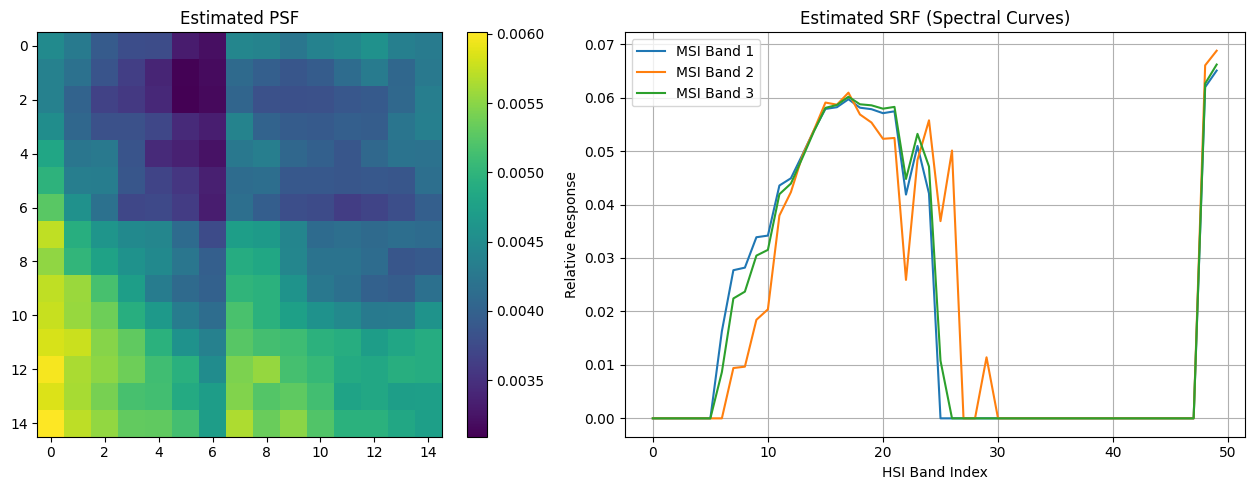

In [27]:
ratio = 8

# 1) Figure out your shapes & bands
H_lr, W_lr, hs_bands = LR_HSI_test_1.shape
H_hr, W_hr, ms_bands = HR_MSI_test_1.shape
ker_size = 2 * ratio - 1  # whatever ratio you chose

# 2) Build input tensors
LR_HSI_tensor = (
    torch.from_numpy(LR_HSI_test_1)
         .permute(2,0,1)          # (C_hsi, H_lr, W_lr)
         .unsqueeze(0)            # (1, C_hsi, H_lr, W_lr)
         .float()
         .to(device)
)
HR_MSI_tensor = (
    torch.from_numpy(HR_MSI_test_1)
         .permute(2,0,1)          # (C_msi, H_hr, W_hr)
         .unsqueeze(0)            # (1, C_msi, H_hr, W_hr)
         .float()
         .to(device)
)

# 3) Instantiate and eval
blind_model = BlindNet(hs_bands, ms_bands, ker_size, ratio).to(device)
blind_model.eval()

# 4) Count params
total_params_blind = sum(
    p.numel() for p in blind_model.parameters() if p.requires_grad
)
print(f"Total parameters in blind model: {total_params_blind:,}")

# 5) Compute FLOPs for one forward
#    Use the same shapes actually fed in:
dummy_Y = torch.randn(1, hs_bands, H_lr, W_lr, device=device)
dummy_Z = torch.randn(1, ms_bands, H_hr, W_hr, device=device)
flops_blind = FlopCountAnalysis(blind_model, (dummy_Y, dummy_Z)).total()
print(f"Total FLOPs (1× forward): {flops_blind:,}")

# 6) Measure peak GPU memory during training
torch.cuda.reset_peak_memory_stats(device)
start_time = time.time()

# run blind training (this will internally step and clamp)
psf_est, srf_est = train_blindnet(
    LR_HSI_tensor,
    HR_MSI_tensor,
    ratio=ratio,
    max_iter=5000
)

peak_bytes = torch.cuda.max_memory_allocated(device)
peak_mb    = peak_bytes / 1024**2

end_time = time.time()
print(f"Blind training took {end_time - start_time:.1f}s")
print(f"Peak GPU memory during training: {peak_mb:.1f} MB")

# 7) Finally, plot the estimated PSF and SRF
plot_psf_srf(psf_est, srf_est)

In [28]:
# 1) Prepare SDM training data
# ------------------------------------------------
H_lr, W_lr, C_hs = LR_HSI_test_1.shape
spec_matrix = (
    torch.from_numpy(LR_HSI_test_1.astype(np.float32))
         .permute(2,0,1)            # (C_hs, H_lr, W_lr)
         .reshape(C_hs, -1)         # (C_hs, H_lr*W_lr)
         .t()                       # (H_lr*W_lr, C_hs)
         .to(device)
)

# 2) Prepare inference tensors
# ------------------------------------------------
# hsi_lr: (1, C_hs, H_lr, W_lr)
hsi_lr = (
    torch.from_numpy(LR_HSI_test_1.astype(np.float32))
         .permute(2,0,1)
         .unsqueeze(0)
         .to(device)
)
# msi_hr: (1, C_ms, H_hr, W_hr)
H_hr, W_hr, C_ms = HR_MSI_test_1.shape
msi_hr = (
    torch.from_numpy(HR_MSI_test_1.astype(np.float32))
         .permute(2,0,1)
         .unsqueeze(0)
         .to(device)
)

_, srf, wavelengths = apply_srf(LR_HSI_test_1, band_specs, fwhm_factor=4.2)

# PSF and SRF from BlindNet
# ------------------------------------------------
psf = (
    torch.from_numpy(psf_est.astype(np.float32))
         .unsqueeze(0).unsqueeze(0)  # (1,1,k,k)
         .to(device)
)
srf = (
    torch.from_numpy(srf.astype(np.float32))
         .permute(0,1)               # ensure (C_ms, C_hs)
         .unsqueeze(-1).unsqueeze(-1)  # (C_ms,C_hs,1,1)
         .to(device)
)

# 3) Train SDM
# ------------------------------------------------
sdm_cfg = SDMConfig(
    batch_size=512,
    lr=1e-2,
    epochs=30000,
    hidden=512,
    layers=4,
    timesteps=1000
)

sdm_time_start = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
sdm_time_end = time.perf_counter()
sdm_training_time = sdm_time_end-sdm_time_start

# report SDM params 
t_vec = torch.full((spec_matrix.size(0),), 200, dtype=torch.long, device=device)
_, num_params_sdm, _ = get_flops_fvcore(sdm.net, (spec_matrix, t_vec))
print(f"SDM params: {num_params_sdm:,}")

# 4) Patch‑wise SDP inference
# ------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=1e-3)
ratio = 8
patch_hr = 32
patch_lr = patch_hr // ratio   
hr_patches = torchkits.extract_patches(msi_hr, kernel=patch_hr, stride=patch_hr)
lr_patches = torchkits.extract_patches(hsi_lr, kernel=patch_lr, stride=patch_lr)
N = hr_patches.size(0)         
batch_size = 32
n_batches  = math.ceil(N / batch_size)

all_sr = []
t0 = time.perf_counter()
pbar = tqdm(range(n_batches),
            desc="Batched SDP",
            total=n_batches,
            dynamic_ncols=True)

for b in pbar:
    i0 = b * batch_size
    i1 = min(i0 + batch_size, N)
    lr_batch = lr_patches[i0:i1]    # (B, C_hs, 4, 4)
    hr_batch = hr_patches[i0:i1]    # (B, C_ms,32,32)

    sr_batch, batch_loss = reconstruct_hsi_batch(
        sdm,
        lr_batch,
        hr_batch,
        psf,
        srf,
        ratio=ratio,
        lam_A   = sdp_cfg.lam_gamma,
        lam_B   = 1.0,
        gamma   = sdp_cfg.lam_gamma,
        inner_K = sdp_cfg.inner_K,
        lr      = sdp_cfg.lr,
        device  = device
    )

    all_sr.append(sr_batch)
    pbar.set_postfix(loss=f"{batch_loss:.3e}")

t1 = time.perf_counter()
sdp_time = t1-t0

total_training_time = sdp_time + sdm_training_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = 50    # number of hyperspectral bands
C_ms = 3     # number of multispectral bands
h_lr, w_lr = 64, 64
ratio = 8
h_hr, w_hr = h_lr * ratio, w_lr * ratio

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# stitch back
sr_patches = torch.cat(all_sr, dim=0)  # (N, C_hs,32,32)
full_sr, _, _ = torchkits.aggregate_patches(
    sr_patches,
    height=msi_hr.shape[2],
    width =msi_hr.shape[3],
    kernel=patch_hr,
    stride=patch_hr,
    pad_num=0,
    patch=1
)
SR_image_1 = full_sr.squeeze(0).permute(1,2,0).cpu().numpy()
print("Final SR image shape:", SR_image_1.shape)

print("SR image max:", SR_image_1.max())
print("SR image min:", SR_image_1.min())
print("SR image mean:", SR_image_1.mean())

# save
np.save(f"{uh_sdp_folder_path}/UH_topleft.npy", SR_image_1)
print("Saved SR HSI 1 at location specified in uh_sdp_folder_path.")

SDM: 100%|██████████| 30000/30000 [19:51<00:00, 25.19it/s, loss=9.511e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


SDM params: 3,584,110


Batched SDP:   0%|          | 0/8 [00:00<?, ?it/s]

Training completed in  2180.99 seconds


Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


FLOPs: 188578004992
GPU memory consumed: 2876.20 MB
Inference time: 0.1578 seconds
Final SR image shape: (512, 512, 50)
SR image max: 1.0
SR image min: 0.0
SR image mean: 0.4001314
Saved SR HSI 1 at location specified in uh_sdp_folder_path.


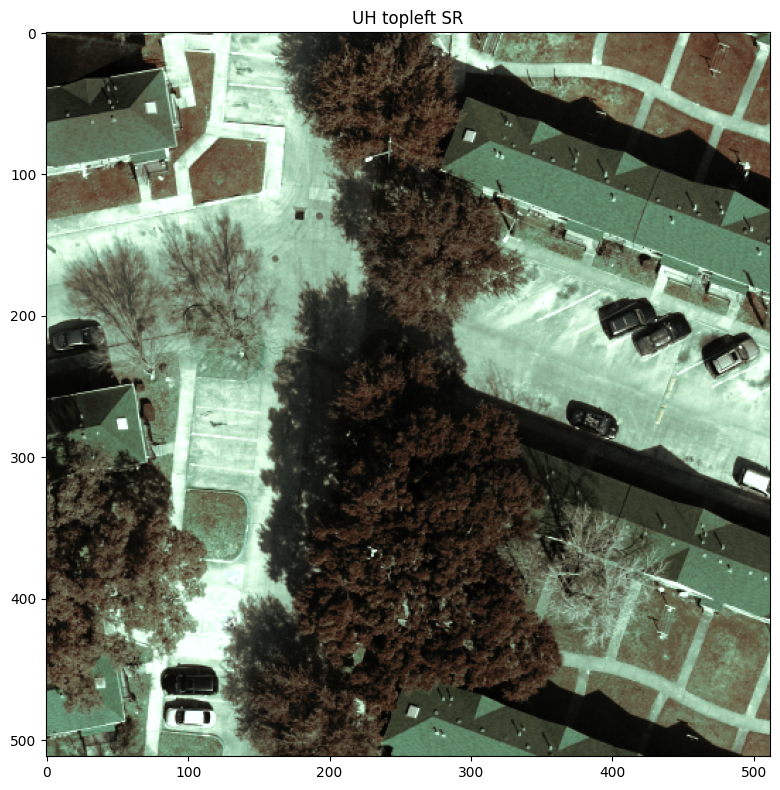

In [29]:
visualize_hsi_single(SR_image_1, (20,13,8), "UH topleft SR")

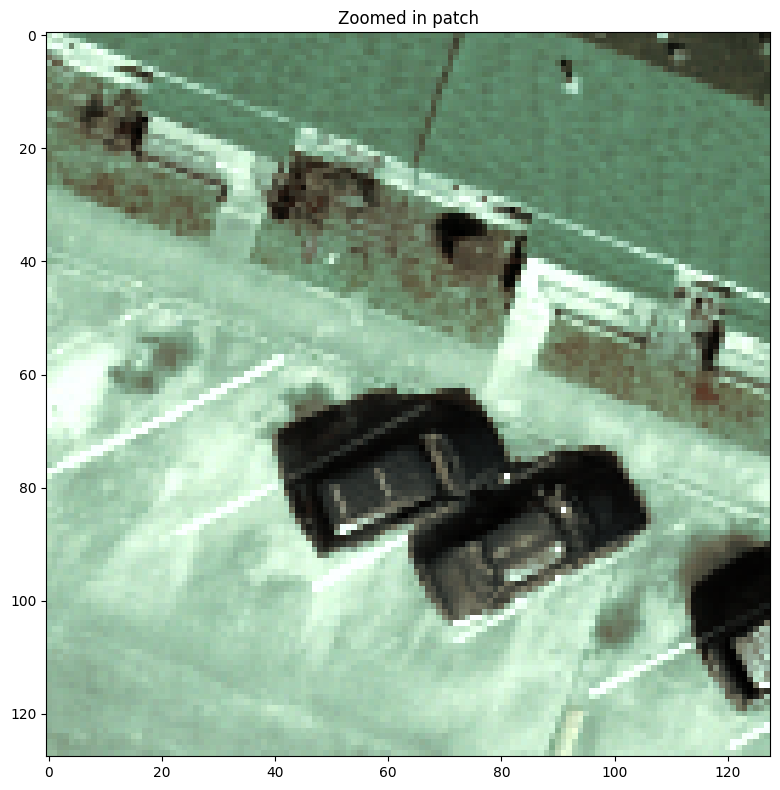

In [30]:
patch = extract_patch_at_coordinates(SR_image_1, 125, 350, patch_size=128)
visualize_hsi_single(patch, (20,13,8), "Zoomed in patch")

Super resolving UH image 2

Unsupported operator aten::sum encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::mul encountered 1 time(s)
Unsupported operator aten::repeat encountered 1 time(s)


Total parameters in blind model: 375
Total FLOPs (1× forward): 177,561,600


Blind PSF/SRF Estimation:   0%|          | 0/5000 [00:00<?, ?it/s]

Blind training took 142.3s
Peak GPU memory during training: 198.5 MB


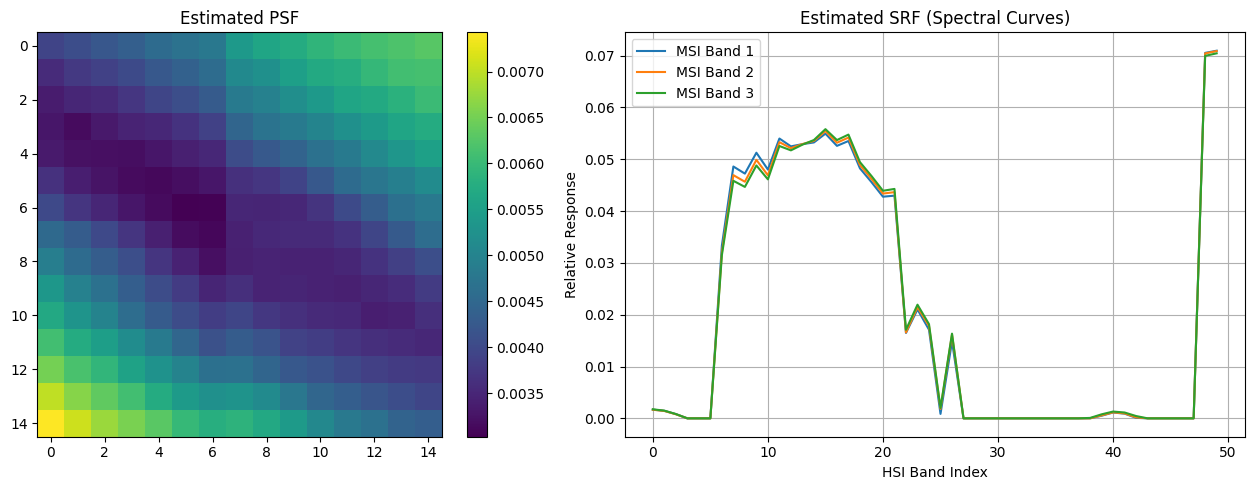

In [31]:
ratio = 8

# 1) Figure out your shapes & bands
H_lr, W_lr, hs_bands = LR_HSI_test_2.shape
H_hr, W_hr, ms_bands = HR_MSI_test_2.shape
ker_size = 2 * ratio - 1  # whatever ratio you chose

# 2) Build input tensors
LR_HSI_tensor = (
    torch.from_numpy(LR_HSI_test_2)
         .permute(2,0,1)          # (C_hsi, H_lr, W_lr)
         .unsqueeze(0)            # (1, C_hsi, H_lr, W_lr)
         .float()
         .to(device)
)
HR_MSI_tensor = (
    torch.from_numpy(HR_MSI_test_2)
         .permute(2,0,1)          # (C_msi, H_hr, W_hr)
         .unsqueeze(0)            # (1, C_msi, H_hr, W_hr)
         .float()
         .to(device)
)

# 3) Instantiate and eval
blind_model = BlindNet(hs_bands, ms_bands, ker_size, ratio).to(device)
blind_model.eval()

# 4) Count params
total_params_blind = sum(
    p.numel() for p in blind_model.parameters() if p.requires_grad
)
print(f"Total parameters in blind model: {total_params_blind:,}")

# 5) Compute FLOPs for one forward
#    Use the same shapes actually fed in:
dummy_Y = torch.randn(1, hs_bands, H_lr, W_lr, device=device)
dummy_Z = torch.randn(1, ms_bands, H_hr, W_hr, device=device)
flops_blind = FlopCountAnalysis(blind_model, (dummy_Y, dummy_Z)).total()
print(f"Total FLOPs (1× forward): {flops_blind:,}")

# 6) Measure peak GPU memory during training
torch.cuda.reset_peak_memory_stats(device)
start_time = time.time()

# run blind training (this will internally step and clamp)
psf_est, srf_est = train_blindnet(
    LR_HSI_tensor,
    HR_MSI_tensor,
    ratio=ratio,
    max_iter=5000
)

peak_bytes = torch.cuda.max_memory_allocated(device)
peak_mb    = peak_bytes / 1024**2

end_time = time.time()
print(f"Blind training took {end_time - start_time:.1f}s")
print(f"Peak GPU memory during training: {peak_mb:.1f} MB")

# 7) Finally, plot the estimated PSF and SRF
plot_psf_srf(psf_est, srf_est)

In [32]:
# 1) Prepare SDM training data
# ------------------------------------------------
H_lr, W_lr, C_hs = LR_HSI_test_2.shape
spec_matrix = (
    torch.from_numpy(LR_HSI_test_2.astype(np.float32))
         .permute(2,0,1)            # (C_hs, H_lr, W_lr)
         .reshape(C_hs, -1)         # (C_hs, H_lr*W_lr)
         .t()                       # (H_lr*W_lr, C_hs)
         .to(device)
)

# 2) Prepare inference tensors
# ------------------------------------------------
# hsi_lr: (1, C_hs, H_lr, W_lr)
hsi_lr = (
    torch.from_numpy(LR_HSI_test_2.astype(np.float32))
         .permute(2,0,1)
         .unsqueeze(0)
         .to(device)
)
# msi_hr: (1, C_ms, H_hr, W_hr)
H_hr, W_hr, C_ms = HR_MSI_test_2.shape
msi_hr = (
    torch.from_numpy(HR_MSI_test_2.astype(np.float32))
         .permute(2,0,1)
         .unsqueeze(0)
         .to(device)
)

_, srf, wavelengths = apply_srf(LR_HSI_test_2, band_specs, fwhm_factor=4.2)

# PSF and SRF from BlindNet
# ------------------------------------------------
psf = (
    torch.from_numpy(psf_est.astype(np.float32))
         .unsqueeze(0).unsqueeze(0)  # (1,1,k,k)
         .to(device)
)
srf = (
    torch.from_numpy(srf.astype(np.float32))
         .permute(0,1)               # ensure (C_ms, C_hs)
         .unsqueeze(-1).unsqueeze(-1)  # (C_ms,C_hs,1,1)
         .to(device)
)

# 3) Train SDM
# ------------------------------------------------
sdm_cfg = SDMConfig(
    batch_size=512,
    lr=1e-2,
    epochs=30000,
    hidden=512,
    layers=4,
    timesteps=1000
)

sdm_start_time = time.perf_counter()
sdm = train_sdm(spec_matrix, sdm_cfg, device)
sdm_end_time = time.perf_counter()
sdm_training_time = sdm_end_time - sdm_start_time

# report SDM params & FLOPs
t_vec = torch.full((spec_matrix.size(0),), 200, dtype=torch.long, device=device)
_, num_params_sdm, _ = get_flops_fvcore(sdm.net, (spec_matrix, t_vec))
print(f"SDM params: {num_params_sdm:,}")

# 4) Patch‑wise SDP inference
# ------------------------------------------------
sdp_cfg = SDPConfig(lam_gamma=1e-3, inner_K=3, lr=1e-3)
ratio = 8
patch_hr = 32
patch_lr = patch_hr // ratio   
hr_patches = torchkits.extract_patches(msi_hr, kernel=patch_hr, stride=patch_hr)
lr_patches = torchkits.extract_patches(hsi_lr, kernel=patch_lr, stride=patch_lr)
N = hr_patches.size(0)         
batch_size = 32
n_batches  = math.ceil(N / batch_size)

all_sr = []
t0 = time.perf_counter()
pbar = tqdm(range(n_batches),
            desc="Batched SDP",
            total=n_batches,
            dynamic_ncols=True)

for b in pbar:
    i0 = b * batch_size
    i1 = min(i0 + batch_size, N)
    lr_batch = lr_patches[i0:i1]    # (B, C_hs, 4, 4)
    hr_batch = hr_patches[i0:i1]    # (B, C_ms,32,32)

    sr_batch, batch_loss = reconstruct_hsi_batch(
        sdm,
        lr_batch,
        hr_batch,
        psf,
        srf,
        ratio=ratio,
        lam_A   = sdp_cfg.lam_gamma,
        lam_B   = 1.0,
        gamma   = sdp_cfg.lam_gamma,
        inner_K = sdp_cfg.inner_K,
        lr      = sdp_cfg.lr,
        device  = device
    )

    all_sr.append(sr_batch)
    pbar.set_postfix(loss=f"{batch_loss:.3e}")

t1 = time.perf_counter()
sdp_time = t1-t0

total_training_time = sdp_time + sdm_training_time
print(f"Training completed in {total_training_time: .2f} seconds")

# Profiling the FLOPs, GPU memory, and inference time on a single forward pass of the model
C_hs = 50    # number of hyperspectral bands
C_ms = 3     # number of multispectral bands
h_lr, w_lr = 64, 64
ratio = 8
h_hr, w_hr = h_lr * ratio, w_lr * ratio

# Create dummy input batches (batch size 1)
hsi_lr_infer = torch.randn(1, C_hs, h_lr, w_lr).to('cuda')
hsi_lr_infer.requires_grad_(False)
msi_hr_infer = torch.randn(1, C_ms, h_hr, w_hr).to('cuda')
msi_hr_infer.requires_grad_(False)

inference_time, peak_memory = run_single_sdp_forward(
    sdm=sdm,
    hsi_lr=hsi_lr_infer,
    msi_hr=msi_hr_infer,
    psf=psf,
    srf=srf,
    ratio=ratio,
    device='cuda'
)

# Initialize wrapper
sdp_wrapper = SDPForwardWrapper(sdm, psf, srf, ratio).to('cuda')

# FLOPs (ensure inputs have gradients disabled)
flops = FlopCountAnalysis(sdp_wrapper, (hsi_lr_infer, msi_hr_infer))
flops_total = flops.total()

print(f"FLOPs: {flops_total}")
print(f"GPU memory consumed: {peak_memory / (1024 ** 2):.2f} MB")
print(f"Inference time: {inference_time:.4f} seconds")

# stitch back
sr_patches = torch.cat(all_sr, dim=0)  # (N, C_hs,32,32)
full_sr, _, _ = torchkits.aggregate_patches(
    sr_patches,
    height=msi_hr.shape[2],
    width =msi_hr.shape[3],
    kernel=patch_hr,
    stride=patch_hr,
    pad_num=0,
    patch=1
)
SR_image_2 = full_sr.squeeze(0).permute(1,2,0).cpu().numpy()
print("Final SR image shape:", SR_image_2.shape)

print("SR image max:", SR_image_2.max())
print("SR image min:", SR_image_2.min())
print("SR image mean:", SR_image_2.mean())

# save
np.save(f"{uh_sdp_folder_path}/UH_bottomright.npy", SR_image_2)
print("Saved SR HSI 2 at location specified in uh_sdp_folder_path.")

SDM: 100%|██████████| 30000/30000 [21:29<00:00, 23.27it/s, loss=5.311e-03]
Unsupported operator aten::mul encountered 5 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)
Unsupported operator aten::add encountered 6 time(s)


SDM params: 3,584,110


Batched SDP:   0%|          | 0/8 [00:00<?, ?it/s]

Training completed in  2297.75 seconds


Unsupported operator aten::rand encountered 1 time(s)
Unsupported operator aten::randn_like encountered 1 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::add encountered 7 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::exp encountered 1 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::silu encountered 7 time(s)


FLOPs: 188578004992
GPU memory consumed: 2876.20 MB
Inference time: 0.1551 seconds
Final SR image shape: (512, 512, 50)
SR image max: 1.0
SR image min: 0.0
SR image mean: 0.5215033
Saved SR HSI 2 at location specified in uh_sdp_folder_path.


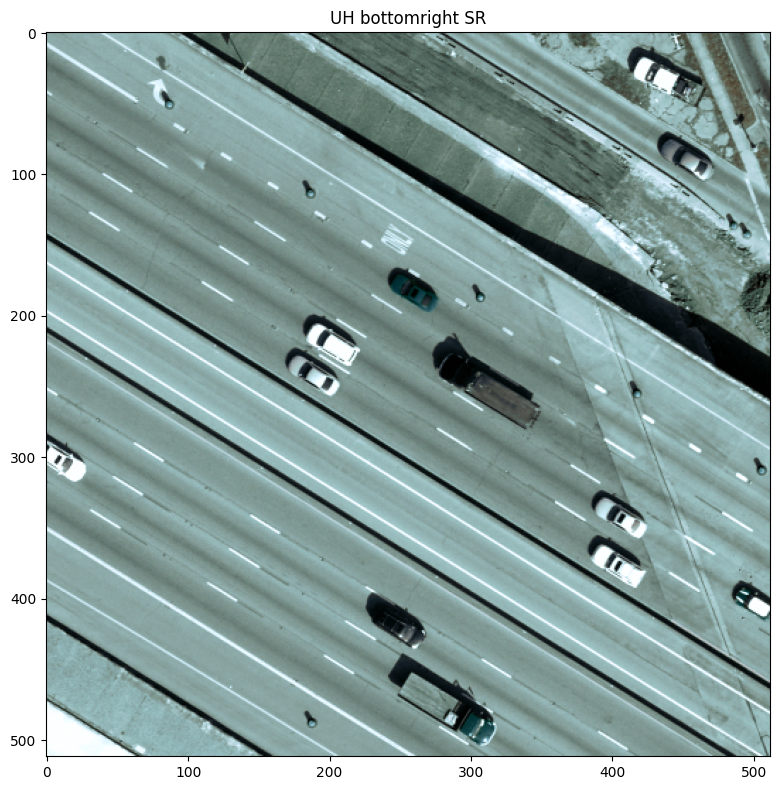

In [33]:
visualize_hsi_single(SR_image_2, (20,13,8), "UH bottomright SR")

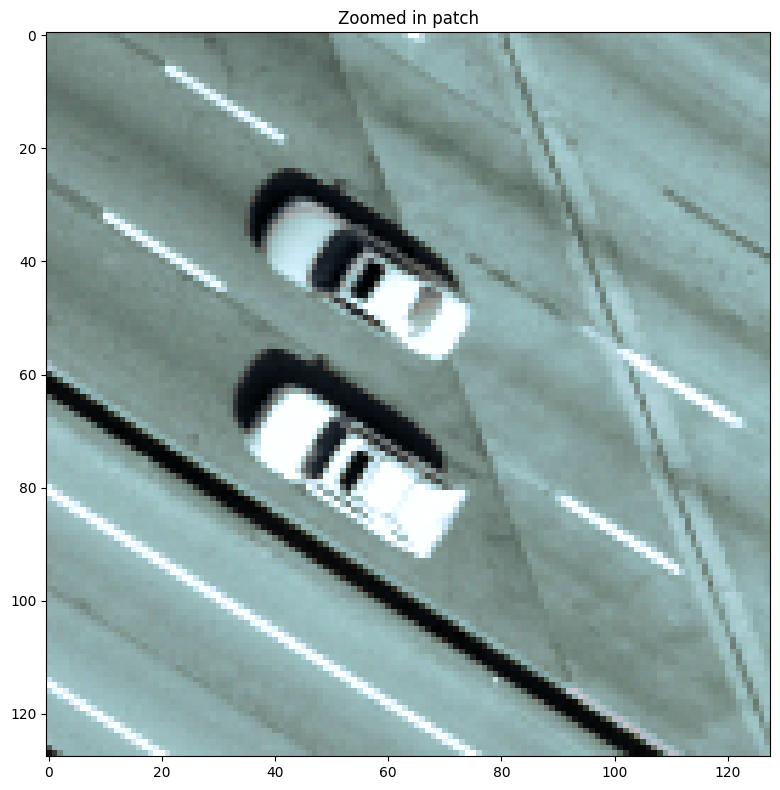

In [34]:
patch = extract_patch_at_coordinates(SR_image_2, 300, 350, patch_size=128)
visualize_hsi_single(patch, (20,13,8), "Zoomed in patch")